In [1291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import io
import os

In [1292]:
def getStockMarketData(ticker):
    '''
    timestamp,open,high,low,close,basevolume,usdtvolume
    '''
    # If you have already saved data, just load it from the file
    df = pd.read_csv(f'./data/stock_market_data-{ticker}.csv')
    
    # Convert Unix timestamp to datetime
    # If timestamp is in seconds (like 1751472000), convert directly
    # If timestamp is in milliseconds, divide by 1000 first
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    
    # Clean the data - remove rows where OHLC values are missing
    # Keep only rows where open, high, low, close are not null and not empty strings
    df = df.replace('', np.nan)  # Replace empty strings with NaN
    df = df.dropna(subset=['open', 'high', 'low', 'close'])  # Drop rows with missing OHLC data
    
    # Convert OHLC columns to numeric if they're not already
    numeric_columns = ['open', 'high', 'low', 'close', 'basevolume', 'usdtvolume']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Optionally, you can also filter out rows where volume is 0 if that indicates invalid data
    # df = df[df['basevolume'] > 0]
    
    return df

def getOperation(file_path):
    '''
    timestamp,Decision,Hands
    '''
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Operation file {file_path} does not exist.")
    
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    
    # Clean operation data if needed
    df = df.replace('', np.nan)
    df = df.dropna()  # Remove rows with any missing values
    
    return df

In [1293]:
def sync_data_by_date_range(df_market, df_operation):
    """
    Get date range from df_operation and sync with df_market data
    If date exists in df_market but not in df_operation, add it to df_operation with 0 values
    Returns filtered dataframes with common date range
    """
    # Get the date range from df_operation (start and end dates)
    df_market = df_market.sort_index()
    operation_start_date = df_operation.index.min()
    operation_end_date = df_operation.index.max()
    
    print(f"Operation date range: {operation_start_date} to {operation_end_date}")
    
    # Filter df_market to the same date range
    df_market_filtered = df_market.loc[operation_start_date:operation_end_date]
    
    print(f"Market data entries in date range: {len(df_market_filtered)}")
    print(f"Operation data entries: {len(df_operation)}")
    
    # Reindex df_operation to match df_market_filtered dates, filling missing dates with 0
    df_operation_synced = df_operation.reindex(df_market_filtered.index, fill_value=0)
    
    # Keep the market data as is (already filtered to the date range)
    df_market_synced = df_market_filtered
    
    print(f"After synchronization:")
    print(f"Number of dates: {len(df_market_synced)}")
    print(f"Date range: {df_market_synced.index.min()} to {df_market_synced.index.max()}")
    
    return df_market_synced, df_operation_synced

def sync_data_by_minute_interval(df_market, df_operation, interval='1T'):
    """
    Resample both dataframes to the specified minute interval (default 1 minute)
    Fills missing intervals with 0 for operations
    """
    # Resample market data to the specified interval using forward fill for OHLCV data
    df_market = df_market.sort_index()
    operation_start_date = df_operation.index.min()
    operation_end_date = df_operation.index.max()
    
    # Resample operation data to the specified interval, filling missing intervals with 0
    df_market_filtered = df_market.loc[operation_start_date:operation_end_date]
    
    print(f"After resampling to {interval}:")
    print(f"Market data entries: {len(df_market_filtered)}")
    print(f"Operation data entries: {len(df_operation)}")
    
    return df_market_filtered, df_operation

In [1294]:
def calculate_returns(df_market_synced, df_operation_synced, initial_capital=1000):
    """
    Calculate returns based on trading operations with high initial capital
    Decision: 1 = buy, -1 = sell, 0 = hold
    Hands: number of shares to trade
    """
    # Create a copy and ensure proper data types
    df_combined = df_market_synced.copy()
    df_combined['Decision'] = pd.to_numeric(df_operation_synced['Decision'], errors='coerce').fillna(0).astype(int)
    df_combined['Hands'] = pd.to_numeric(df_operation_synced['Hands'], errors='coerce').fillna(0).astype(int)

    initial_capital = initial_capital * df_combined['close'][0]
    
    # Initialize tracking variables
    portfolio_values = []
    cash = float(initial_capital)
    shares_held = int(0)
    trade_log = []
    
    for i, (date, row) in enumerate(df_combined.iterrows()):
        price = float(row['close'])
        decision = int(row['Decision'])
        hands = int(row['Hands'])
        
        # BUY LOGIC
        if decision == 1 and hands > 0:
            trade_cost = float(hands) * price
            if cash >= trade_cost:
                cash = cash - trade_cost
                shares_held = shares_held + hands
                trade_log.append({
                    'date': date,
                    'action': 'BUY',
                    'shares': hands,
                    'price': price,
                    'value': trade_cost,
                    'cash_after': cash,
                    'shares_after': shares_held
                })
            else:
                # Partial buy with available cash
                affordable_shares = int(cash / price)
                if affordable_shares > 0:
                    actual_cost = float(affordable_shares) * price
                    cash = cash - actual_cost
                    shares_held = shares_held + affordable_shares
                    trade_log.append({
                        'date': date,
                        'action': 'PARTIAL_BUY',
                        'shares': affordable_shares,
                        'price': price,
                        'value': actual_cost,
                        'cash_after': cash,
                        'shares_after': shares_held
                    })
        
        # SELL LOGIC
        elif decision == -1 and hands > 0:
            shares_to_sell = min(hands, shares_held)
            if shares_to_sell > 0:
                trade_value = float(shares_to_sell) * price
                cash = cash + trade_value
                shares_held = shares_held - shares_to_sell
                trade_log.append({
                    'date': date,
                    'action': 'SELL',
                    'shares': shares_to_sell,
                    'price': price,
                    'value': trade_value,
                    'cash_after': cash,
                    'shares_after': shares_held
                })
        
        # Calculate current portfolio value
        current_portfolio_value = cash + (float(shares_held) * price)
        portfolio_values.append(current_portfolio_value)
    
    # Add calculated columns to dataframe
    df_combined['Portfolio_Value'] = portfolio_values
    df_combined['Cash'] = cash
    df_combined['Shares_Held'] = shares_held
    
    # Calculate returns
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital
    
    # Calculate daily returns
    df_combined['Daily_Return'] = df_combined['Portfolio_Value'].pct_change()
    
    # Calculate cumulative returns
    df_combined['Cumulative_Return'] = (df_combined['Portfolio_Value'] / initial_capital) - 1
    
    # Calculate buy and hold return for comparison
    initial_price = float(df_combined['close'].iloc[0])
    final_price = float(df_combined['close'].iloc[-1])
    buy_hold_return = (final_price - initial_price) / initial_price
    
    # Performance metrics
    performance_metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_value,
        'Total Return': total_return,
        'Total Return (%)': total_return * 100,
        'Buy & Hold Return (%)': buy_hold_return * 100,
        'Excess Return (%)': (total_return - buy_hold_return) * 100,
        'Number of Trades': len(trade_log),
        'Final Cash': cash,
        'Final Shares': shares_held,
        'Final Stock Price': final_price,
        'Annualized Return (%)': (((final_value / initial_capital) ** (252 / len(df_combined))) - 1) * 100,
    }
    
    # Calculate additional risk metrics
    if len(df_combined['Daily_Return'].dropna()) > 1:
        daily_returns = df_combined['Daily_Return'].dropna()
        performance_metrics.update({
            'Volatility (%)': daily_returns.std() * np.sqrt(252) * 100,
            'Sharpe Ratio': (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252)) if daily_returns.std() > 0 else 0,
            'Max Drawdown (%)': ((df_combined['Portfolio_Value'] / df_combined['Portfolio_Value'].cummax()) - 1).min() * 100
        })
    
    return df_combined, pd.DataFrame(trade_log), performance_metrics


def calculate_returns_minute(df_market_synced, df_operation_synced, initial_capital=1000):
    """
    Calculate minute-based returns on BTC/crypto market with enhanced HFT metrics
    Decision: 1 = buy, -1 = sell, 0 = hold
    Hands: number of coins to trade
    initial_capital: USD value to start with (converted to BTC at 1st price)
    """
    # Ensure correct types
    df_combined = df_market_synced.copy()
    df_combined['Decision'] = pd.to_numeric(df_operation_synced['Decision'], errors='coerce').fillna(0).astype(int)
    df_combined['Hands'] = pd.to_numeric(df_operation_synced['Hands'], errors='coerce').fillna(0).astype(float)
    
    # Instead of buying 1000 shares, capital is measured in USD, buy BTC at first price
    first_price = float(df_combined['close'].iloc[0])
    initial_cash = float(initial_capital) * first_price
    cash = initial_cash
    btc_held = 0.0
    portfolio_values = []
    trade_log = []
    
    # Additional tracking for HFT metrics
    position_changes = []
    position_history = []
    holding_times = []
    trade_directions = []
    
    for i, (date, row) in enumerate(df_combined.iterrows()):
        price = float(row['close'])
        decision = int(row['Decision'])
        hands = float(row['Hands'])
        
        prev_btc = btc_held
        
        # BUY LOGIC (buy "hands" BTC if we have enough cash)
        if decision == 1 and hands > 0:
            cost = hands * price
            if cash >= cost:
                btc_held += hands
                cash -= cost
                trade_log.append({
                    'date': date,
                    'action': 'BUY',
                    'btc': hands,
                    'price': price,
                    'value': cost,
                    'cash_after': cash,
                    'btc_after': btc_held,
                    'timestamp': i
                })
                trade_directions.append(1)
            else:
                affordable_btc = cash / price
                if affordable_btc > 0:
                    btc_held += affordable_btc
                    cash = 0.0
                    trade_log.append({
                        'date': date,
                        'action': 'PARTIAL_BUY',
                        'btc': affordable_btc,
                        'price': price,
                        'value': affordable_btc * price,
                        'cash_after': cash,
                        'btc_after': btc_held,
                        'timestamp': i
                    })
                    trade_directions.append(1)
        
        # SELL LOGIC (sell min(hands, btc_held))
        elif decision == -1 and hands > 0:
            btc_to_sell = min(hands, btc_held)
            if btc_to_sell > 0:
                value = btc_to_sell * price
                btc_held -= btc_to_sell
                cash += value
                trade_log.append({
                    'date': date,
                    'action': 'SELL',
                    'btc': btc_to_sell,
                    'price': price,
                    'value': value,
                    'cash_after': cash,
                    'btc_after': btc_held,
                    'timestamp': i
                })
                trade_directions.append(-1)
        
        # Track position changes for HFT metrics
        position_change = abs(btc_held - prev_btc)
        position_changes.append(position_change)
        position_history.append(btc_held)
        
        # Portfolio value in USD
        portfolio_value = cash + btc_held * price
        portfolio_values.append(portfolio_value)
    
    # Add result columns
    df_combined['Portfolio_Value'] = portfolio_values
    df_combined['Cash'] = cash
    df_combined['Shares_Held'] = position_history
    
    # Returns
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_cash) / initial_cash
    
    # Minute-over-minute returns
    df_combined['Minute_Return'] = df_combined['Portfolio_Value'].pct_change()
    df_combined['Cumulative_Return'] = (df_combined['Portfolio_Value'] / initial_cash) - 1
    
    # Buy-and-hold (if you bought BTC at beginning and held):
    initial_btc = initial_cash / first_price
    final_btc_price = float(df_combined['close'].iloc[-1])
    buy_hold_value = initial_btc * final_btc_price
    buy_hold_return = (buy_hold_value - initial_cash) / initial_cash
    
    # Calculate annualization factor based on number of minutes
    N = len(df_combined)
    MINUTES_PER_YEAR = 525600     # 365 * 24 * 60
    if N > 1 and final_value > 0 and initial_capital > 0:
        total_log_return = np.log(final_value / initial_capital)
        annualization = MINUTES_PER_YEAR / N
        try:
            ann_return = (np.exp(total_log_return * annualization) - 1) * 100
        except OverflowError:
            ann_return = np.nan
    else:
        ann_return = 0
    
    # ========== ENHANCED BTC/CRYPTO HFT METRICS ==========
    
    # 1. Microtrade Intensity (trades per hour)
    total_trades = len(trade_log)
    total_minutes = len(df_combined)
    microtrade_intensity = total_trades / (total_minutes / 60) if total_minutes > 0 else 0
    
    # 2. Position Oscillation Rate (full reversals per hour)
    position_signs = np.sign(position_history)
    position_flips = np.sum((position_signs[1:] != position_signs[:-1]) & (position_signs[1:] != 0))
    oscillation_rate = position_flips / (total_minutes / 60) if total_minutes > 0 else 0
    
    # 3. Holding Time Distribution
    if len(trade_log) > 1:
        trade_timestamps = [t['timestamp'] for t in trade_log if t['action'] in ['SELL', 'BUY']]
        holding_times = np.diff(trade_timestamps)
        mean_holding_time = np.mean(holding_times) if len(holding_times) > 0 else 0
        median_holding_time = np.median(holding_times) if len(holding_times) > 0 else 0
        trades_under_5min = np.sum(holding_times <= 5) / len(holding_times) * 100 if len(holding_times) > 0 else 0
        trades_under_15min = np.sum(holding_times <= 15) / len(holding_times) * 100 if len(holding_times) > 0 else 0
        trades_under_1hr = np.sum(holding_times <= 60) / len(holding_times) * 100 if len(holding_times) > 0 else 0
    else:
        mean_holding_time = median_holding_time = 0
        trades_under_5min = trades_under_15min = trades_under_1hr = 0
    
    # 4. Dollar Turnover Rate (daily)
    total_volume = sum([t['value'] for t in trade_log])
    mean_portfolio_value = np.mean(portfolio_values)
    turnover_rate_daily = (total_volume / mean_portfolio_value) * (1440 / total_minutes) if mean_portfolio_value > 0 else 0
    
    # 5. Volatility Exploitation Index (VEI)
    if len(position_changes) > 1 and len(df_combined) > 1:
        sum_position_changes = np.sum(position_changes)
        price_returns = np.abs(df_combined['close'].pct_change().dropna())
        sum_price_volatility = np.sum(price_returns)
        vei = (sum_position_changes / len(position_changes)) / 100 / sum_price_volatility if sum_price_volatility > 0 else 0
    else:
        vei = 0
    
    # 6. High-Frequency Activity Rate
    active_minutes = np.sum([1 for d in df_combined['Decision'] if d != 0])
    activity_rate = (active_minutes / total_minutes) * 100 if total_minutes > 0 else 0
    
    # 7. Dynamic Capital Utilization
    btc_values = df_combined['Shares_Held'] * df_combined['close']
    cash_values = df_combined['Portfolio_Value'] - btc_values
    capital_deployed = btc_values / df_combined['Portfolio_Value']
    avg_capital_utilization = np.mean(capital_deployed) * 100
    
    # 8. Trade Direction Bias
    if len(trade_directions) > 0:
        buy_ratio = np.sum([1 for d in trade_directions if d == 1]) / len(trade_directions) * 100
        sell_ratio = 100 - buy_ratio
    else:
        buy_ratio = sell_ratio = 0
    
    # 9. Average Trade Size
    if len(trade_log) > 0:
        avg_trade_size_btc = np.mean([abs(t['btc']) for t in trade_log])
        avg_trade_size_usd = np.mean([t['value'] for t in trade_log])
    else:
        avg_trade_size_btc = avg_trade_size_usd = 0
    
    # Standard performance metrics
    performance_metrics = {
        # === BASIC METRICS ===
        'Initial Capital (USD)': initial_capital,
        'Initial BTC Acquired (BTC)': initial_capital / first_price,
        'Final Portfolio Value (USD)': final_value,
        'Final BTC Held': btc_held,
        'Final Cash (USD)': cash,
        'Final BTC Price (USD)': final_btc_price,
        'Total Return (%)': total_return * 100,
        'Total Return (USD)': final_value - initial_capital,
        'BTC Price Change (%)': (final_btc_price / first_price - 1) * 100,
        'Buy & Hold Return (%)': buy_hold_return * 100,
        'Excess Return over Buy & Hold (%)': (total_return - buy_hold_return) * 100,
        'Annualized Return (%)': ann_return,
        'Number of Trades': len(trade_log),
        
        # === ENHANCED BTC/CRYPTO HFT METRICS ===
        'Microtrade Intensity (trades/hr)': microtrade_intensity,
        'Position Oscillation Rate (flips/hr)': oscillation_rate,
        'Mean Holding Time (min)': mean_holding_time,
        'Median Holding Time (min)': median_holding_time,
        'Trades Closed < 5min (%)': trades_under_5min,
        'Trades Closed < 15min (%)': trades_under_15min,
        'Trades Closed < 1hr (%)': trades_under_1hr,
        'Dollar Turnover Rate (daily)': turnover_rate_daily,
        'Volatility Exploitation Index': vei,
        'High-Frequency Activity Rate (%)': activity_rate,
        'Average Capital Utilization (%)': avg_capital_utilization,
        'Buy Trade Ratio (%)': buy_ratio,
        'Sell Trade Ratio (%)': sell_ratio,
        'Average Trade Size (BTC)': avg_trade_size_btc,
        'Average Trade Size (USD)': avg_trade_size_usd,
    }
    
    # Add standard risk metrics if possible
    if len(df_combined['Minute_Return'].dropna()) > 1:
        min_returns = df_combined['Minute_Return'].dropna()
        annual_vol = min_returns.std() * np.sqrt(MINUTES_PER_YEAR) * 100
        annual_return_mean = min_returns.mean() * MINUTES_PER_YEAR
        sharpe = (annual_return_mean) / (min_returns.std() * np.sqrt(MINUTES_PER_YEAR)) if min_returns.std() > 0 else 0
        max_drawdown = ((df_combined['Portfolio_Value'] / df_combined['Portfolio_Value'].cummax()) - 1).min() * 100
        performance_metrics.update({
            'Volatility (%)': annual_vol,
            'Sharpe Ratio': sharpe,
            'Max Drawdown (%)': max_drawdown
        })
    
    return df_combined, pd.DataFrame(trade_log), performance_metrics

In [1295]:
def plot_performance_analysis(df_results, metrics):
    """
    Create comprehensive performance visualization with enhanced BTC/crypto HFT metrics
    """
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with more subplots for enhanced analysis
    fig = plt.figure(figsize=(24, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # fig.suptitle('Enhanced Bitcoin/Crypto HFT Strategy Performance Analysis', fontsize=18, fontweight='bold')
    
    # 1. Portfolio Value vs BTC Price
    ax1 = fig.add_subplot(gs[0, :2])
    ax1_twin = ax1.twinx()
    
    line1 = ax1.plot(df_results.index, df_results['Portfolio_Value'], 
                     'b-', label='Portfolio Value', linewidth=2.5, alpha=0.8)
    ax1.set_ylabel('Portfolio Value ($)', color='b', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.1f}K'))
    
    line2 = ax1_twin.plot(df_results.index, df_results['close'], 
                          'orange', label='BTC Price', linewidth=2, alpha=0.7)
    ax1_twin.set_ylabel('BTC Price ($)', color='orange', fontweight='bold')
    ax1_twin.tick_params(axis='y', labelcolor='orange', rotation=90)
    ax1_twin.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e3:.1f}K' if x >= 1e3 else f'${x:.1f}'))
    ax1_twin.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax1.set_title('Portfolio Value vs BTC Price', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. Cumulative Returns Comparison
    ax2 = fig.add_subplot(gs[0, 2:])
    strategy_returns = df_results['Cumulative_Return'] * 100
    buy_hold_returns = (df_results['close'] / df_results['close'].iloc[0] - 1) * 100
    
    ax2.plot(df_results.index, strategy_returns, 
             'g-', label='Strategy Return', linewidth=2.5, alpha=0.8)
    ax2.plot(df_results.index, buy_hold_returns, 
             'orange', label='Buy & Hold Return', linestyle='--', linewidth=2, alpha=0.8)
    
    ax2.set_title('Cumulative Returns Comparison', fontweight='bold')
    ax2.set_ylabel('Cumulative Return (%)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Performance text box
    textstr = (
        f'Strategy: {metrics["Total Return (%)"]:.2f}%\n'
        f'Buy&Hold: {metrics["Buy & Hold Return (%)"]:.2f}%\n'
        f'Excess: {metrics["Excess Return over Buy & Hold (%)"]:.2f}%\n'
        f'Sharpe: {metrics.get("Sharpe Ratio", 0):.3f}'
    )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # 3. Trading Activity & Position Changes
    ax3 = fig.add_subplot(gs[1, :2])
    ax3.plot(df_results.index, df_results['close'], 
             'k-', alpha=0.6, label='BTC Price', linewidth=1.5)
    
    buy_dates = df_results[df_results['Decision'] == 1].index
    sell_dates = df_results[df_results['Decision'] == -1].index
    
    if len(buy_dates) > 0:
        ax3.scatter(buy_dates, df_results.loc[buy_dates, 'close'], 
                   color='green', marker='^', s=60, label='Buy', alpha=0.8, edgecolors='darkgreen')
    
    if len(sell_dates) > 0:
        ax3.scatter(sell_dates, df_results.loc[sell_dates, 'close'], 
                   color='red', marker='v', s=60, label='Sell', alpha=0.8, edgecolors='darkred')
    
    ax3.set_ylabel('BTC Price (USD)', fontweight='bold')
    ax3.set_title('High-Frequency Trading Activity', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Portfolio Composition Over Time
    ax4 = fig.add_subplot(gs[1, 2:])
    stock_values = df_results['Shares_Held'] * df_results['close']
    cash_values = df_results['Portfolio_Value'] - stock_values
    
    ax4.fill_between(df_results.index, 0, cash_values, 
                     label='USD Cash', alpha=0.6, color='lightblue')
    ax4.fill_between(df_results.index, cash_values, df_results['Portfolio_Value'], 
                     label='BTC Holdings', alpha=0.6, color='lightcoral')
    
    ax4.set_ylabel('Value (USD)', fontweight='bold')
    ax4.set_title('Portfolio Composition: USD vs BTC', fontweight='bold')
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.1f}K'))
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # 5. BTC Position Size Over Time
    ax5 = fig.add_subplot(gs[2, :2])
    ax5.plot(df_results.index, df_results['Shares_Held'], 
             'purple', linewidth=2, alpha=0.8, label='BTC Position')
    ax5.fill_between(df_results.index, 0, df_results['Shares_Held'], 
                     alpha=0.3, color='purple')
    ax5.set_ylabel('BTC Holdings', fontweight='bold')
    ax5.set_title('BTC Position Size Evolution', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # 6. Minute Returns Distribution
    ax6 = fig.add_subplot(gs[2, 2:])
    minute_returns = df_results['Minute_Return'].dropna() * 100
    if len(minute_returns) > 0:
        ax6.hist(minute_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax6.axvline(minute_returns.mean(), color='red', linestyle='--', 
                   label=f'Mean: {minute_returns.mean():.4f}%')
        ax6.axvline(minute_returns.median(), color='green', linestyle='--', 
                   label=f'Median: {minute_returns.median():.4f}%')
    ax6.set_xlabel('Minute Return (%)', fontweight='bold')
    ax6.set_ylabel('Frequency', fontweight='bold')
    ax6.set_title('Distribution of Minute Returns', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    ax6.legend()
    
    # 7. HFT Metrics Visualization - Bar Chart
    ax7 = fig.add_subplot(gs[3, :2])
    hft_metrics = {
        'Trades/Hr': metrics['Microtrade Intensity (trades/hr)'],
        'Flips/Hr': metrics['Position Oscillation Rate (flips/hr)'],
        'Activity %': metrics['High-Frequency Activity Rate (%)'],
        'Capital Util %': metrics['Average Capital Utilization (%)'],
        'VEI': metrics['Volatility Exploitation Index'] * 10,  # Scale for visibility
    }
    
    bars = ax7.bar(hft_metrics.keys(), hft_metrics.values(), 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
    ax7.set_title('High-Frequency Trading Metrics', fontweight='bold')
    ax7.set_ylabel('Value', fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 8. Holding Time Distribution
    ax8 = fig.add_subplot(gs[3, 2:])
    holding_metrics = {
        '< 5min': metrics['Trades Closed < 5min (%)'],
        '< 15min': metrics['Trades Closed < 15min (%)'],
        '< 1hr': metrics['Trades Closed < 1hr (%)'],
        'Mean (min)': metrics['Mean Holding Time (min)'],
        'Median (min)': metrics['Median Holding Time (min)']
    }
    
    colors = ['#E74C3C', '#F39C12', '#F1C40F', '#2ECC71', '#3498DB']
    bars = ax8.bar(holding_metrics.keys(), holding_metrics.values(), color=colors)
    ax8.set_title('Trade Holding Time Analysis', fontweight='bold')
    ax8.set_ylabel('Value (%/min)', fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')
    # plt.setp(ax8.xaxis.get_majorticklabels(), rotation=15)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Format x-axis for time-series plots
    # for ax in [ax1, ax2, ax3, ax4, ax5]:
    #     ax.tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced metrics table with categorization
    print("\n" + "="*80)
    print("🚀 ENHANCED BITCOIN/CRYPTO HIGH-FREQUENCY TRADING METRICS")
    print("="*80)
    
    # Categorize metrics
    basic_metrics = {
        'Initial Capital (USD)': metrics['Initial Capital (USD)'],
        'Final Portfolio Value (USD)': metrics['Final Portfolio Value (USD)'],
        'Total Return (%)': metrics['Total Return (%)'],
        'Buy & Hold Return (%)': metrics['Buy & Hold Return (%)'],
        'Excess Return over Buy & Hold (%)': metrics['Excess Return over Buy & Hold (%)'],
        'Annualized Return (%)': metrics.get('Annualized Return (%)', 0),
        'Volatility (%)': metrics.get('Volatility (%)', 0),
        'Sharpe Ratio': metrics.get('Sharpe Ratio', 0),
        'Max Drawdown (%)': metrics.get('Max Drawdown (%)', 0),
    }
    
    hft_metrics_display = {
        'Microtrade Intensity (trades/hr)': metrics['Microtrade Intensity (trades/hr)'],
        'Position Oscillation Rate (flips/hr)': metrics['Position Oscillation Rate (flips/hr)'],
        'High-Frequency Activity Rate (%)': metrics['High-Frequency Activity Rate (%)'],
        'Volatility Exploitation Index': metrics['Volatility Exploitation Index'],
        'Average Capital Utilization (%)': metrics['Average Capital Utilization (%)'],
        'Dollar Turnover Rate (daily)': metrics['Dollar Turnover Rate (daily)'],
    }
    
    trading_metrics = {
        'Number of Trades': metrics['Number of Trades'],
        'Mean Holding Time (min)': metrics['Mean Holding Time (min)'],
        'Median Holding Time (min)': metrics['Median Holding Time (min)'],
        'Trades Closed < 5min (%)': metrics['Trades Closed < 5min (%)'],
        'Trades Closed < 15min (%)': metrics['Trades Closed < 15min (%)'],
        'Trades Closed < 1hr (%)': metrics['Trades Closed < 1hr (%)'],
        'Average Trade Size (BTC)': metrics['Average Trade Size (BTC)'],
        'Average Trade Size (USD)': metrics['Average Trade Size (USD)'],
        'Buy Trade Ratio (%)': metrics['Buy Trade Ratio (%)'],
        'Sell Trade Ratio (%)': metrics['Sell Trade Ratio (%)'],
    }
    
    # Format and display each category
    def format_metric_value(key, value):
        if isinstance(value, float):
            if 'Capital' in key or 'Value' in key or 'Cash' in key or 'Price' in key or 'USD' in key:
                if value >= 1e6:
                    return f"${value/1e6:.2f}M"
                elif value >= 1e3:
                    return f"${value/1e3:.2f}K"
                else:
                    return f"${value:,.2f}"
            elif '%' in key or 'Return' in key:
                return f"{value:.2f}%"
            elif 'Ratio' in key or 'Index' in key:
                return f"{value:.4f}"
            elif 'BTC' in key:
                return f"{value:.6f} BTC"
            else:
                return f"{value:.2f}"
        else:
            return str(value)
    
    # Display tables
    print("\n📊 BASIC PERFORMANCE METRICS")
    print("-" * 50)
    for key, value in basic_metrics.items():
        print(f"{key:<35}: {format_metric_value(key, value):>15}")
    
    print("\n⚡ HIGH-FREQUENCY TRADING METRICS")
    print("-" * 50)
    for key, value in hft_metrics_display.items():
        print(f"{key:<35}: {format_metric_value(key, value):>15}")
    
    print("\n💱 TRADING BEHAVIOR METRICS")
    print("-" * 50)
    for key, value in trading_metrics.items():
        print(f"{key:<35}: {format_metric_value(key, value):>15}")
    
    # Special highlights
    print("\n🎯 KEY INSIGHTS")
    print("-" * 50)
    if metrics['Microtrade Intensity (trades/hr)'] > 10:
        print("• HIGH-FREQUENCY STRATEGY: Executing >10 trades per hour")
    if metrics['Trades Closed < 5min (%)'] > 50:
        print("• ULTRA-SHORT HOLDING: >50% of trades closed within 5 minutes")
    if metrics['Volatility Exploitation Index'] > 1:
        print("• HIGH VEI: Strategy highly responsive to market volatility")
    if metrics['Excess Return over Buy & Hold (%)'] > 0:
        print("• ALPHA GENERATION: Strategy outperforming buy-and-hold")
    
    print("\n" + "="*80)
    
    return fig

def plot_performance_analysis_split(df_results, metrics):
    """
    Create comprehensive performance visualization split into 3 separate graphics
    """
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # ===========================
    # GRAPHIC 1: Core Performance Overview (1, 2, 3)
    # ===========================
    fig1 = plt.figure(figsize=(20, 6))
    gs1 = fig1.add_gridspec(1, 3, hspace=0.3, wspace=0.3)
    # fig1.suptitle('Core Performance Overview', fontsize=16, fontweight='bold')
    
    # 1. Portfolio Value vs BTC Price
    ax1 = fig1.add_subplot(gs1[0, 0])
    ax1_twin = ax1.twinx()
    
    line1 = ax1.plot(df_results.index, df_results['Portfolio_Value'], 
                     'b-', label='Portfolio Value', linewidth=2.5, alpha=0.8)
    ax1.set_ylabel('Portfolio Value ($)', color='b', fontweight='bold', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.tick_params(axis='x', rotation=15)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.1f}K'))
    
    line2 = ax1_twin.plot(df_results.index, df_results['close'], 
                          'orange', label='BTC Price', linewidth=2, alpha=0.7)
    ax1_twin.set_ylabel('BTC Price ($)', color='orange', fontweight='bold', fontsize=16)
    ax1_twin.tick_params(axis='y', labelcolor='orange', rotation=90)
    ax1_twin.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e3:.1f}K' if x >= 1e3 else f'${x:.1f}'))
    ax1_twin.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax1.set_title('Portfolio Value vs BTC Price', fontweight='bold', fontsize=20)
    ax1.grid(True, alpha=0.3)
    
    # 2. Cumulative Returns Comparison
    ax2 = fig1.add_subplot(gs1[0, 1])
    strategy_returns = df_results['Cumulative_Return'] * 100
    buy_hold_returns = (df_results['close'] / df_results['close'].iloc[0] - 1) * 100
    
    ax2.plot(df_results.index, strategy_returns, 
             'g-', label='Strategy Return', linewidth=2.5, alpha=0.8)
    ax2.plot(df_results.index, buy_hold_returns, 
             'orange', label='Buy & Hold Return', linestyle='--', linewidth=2, alpha=0.8)
    
    ax2.set_title('Cumulative Returns Comparison', fontweight='bold', fontsize=20)
    ax2.set_ylabel('Cumulative Return (%)', fontweight='bold', fontsize=16)
    ax2.tick_params(axis='x', rotation=15)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Performance text box
    textstr = (
        f'Strategy: {metrics["Total Return (%)"]:.2f}%\n'
        f'Buy&Hold: {metrics["Buy & Hold Return (%)"]:.2f}%\n'
        f'Excess: {metrics["Excess Return over Buy & Hold (%)"]:.2f}%\n'
        f'Sharpe: {metrics.get("Sharpe Ratio", 0):.3f}'
    )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=16,
             verticalalignment='top', bbox=props)
    
    # 3. Trading Activity & Position Changes
    ax3 = fig1.add_subplot(gs1[0, 2])
    ax3.plot(df_results.index, df_results['close'], 
             'k-', alpha=0.6, label='BTC Price', linewidth=1.5)
    
    buy_dates = df_results[df_results['Decision'] == 1].index
    sell_dates = df_results[df_results['Decision'] == -1].index
    
    if len(buy_dates) > 0:
        ax3.scatter(buy_dates, df_results.loc[buy_dates, 'close'], 
                   color='green', marker='^', s=60, label='Buy', alpha=0.8, edgecolors='darkgreen')
    
    if len(sell_dates) > 0:
        ax3.scatter(sell_dates, df_results.loc[sell_dates, 'close'], 
                   color='red', marker='v', s=60, label='Sell', alpha=0.8, edgecolors='darkred')
    
    ax3.set_ylabel('BTC Price (USD)', fontweight='bold', fontsize=16)
    ax3.set_title('High-Frequency Trading Activity', fontweight='bold', fontsize=20)
    ax3.tick_params(axis='x', rotation=15)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # ===========================
    # GRAPHIC 2: Portfolio Composition & Position Analysis (4, 5)
    # ===========================
    fig2 = plt.figure(figsize=(20, 6))
    gs2 = fig2.add_gridspec(1, 2, hspace=0.3, wspace=0.3)
    # fig2.suptitle('Portfolio Composition & Position Analysis', fontsize=16, fontweight='bold')
    
    # 4. Portfolio Composition Over Time
    ax4 = fig2.add_subplot(gs2[0, 0])
    stock_values = df_results['Shares_Held'] * df_results['close']
    cash_values = df_results['Portfolio_Value'] - stock_values
    
    ax4.fill_between(df_results.index, 0, cash_values, 
                     label='USD Cash', alpha=0.6, color='lightblue')
    ax4.fill_between(df_results.index, cash_values, df_results['Portfolio_Value'], 
                     label='BTC Holdings', alpha=0.6, color='lightcoral')
    
    ax4.set_ylabel('Value (USD)', fontweight='bold', fontsize=16)
    ax4.set_title('Portfolio Composition: USD vs BTC', fontweight='bold', fontsize=20)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.1f}K'))
    ax4.tick_params(axis='x', rotation=15)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # 5. BTC Position Size Over Time
    ax5 = fig2.add_subplot(gs2[0, 1])
    ax5.plot(df_results.index, df_results['Shares_Held'], 
             'purple', linewidth=2, alpha=0.8, label='BTC Position')
    ax5.fill_between(df_results.index, 0, df_results['Shares_Held'], 
                     alpha=0.3, color='purple')
    ax5.set_ylabel('BTC Holdings', fontweight='bold', fontsize=16)
    ax5.set_title('BTC Position Size Evolution', fontweight='bold', fontsize=20)
    ax5.tick_params(axis='x', rotation=15)
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    plt.tight_layout()
    plt.show()
    
    # ===========================
    # GRAPHIC 3: Trading Metrics & Analysis (6, 7, 8)
    # ===========================
    fig3 = plt.figure(figsize=(20, 6))
    gs3 = fig3.add_gridspec(1, 3, hspace=0.3, wspace=0.3)
    # fig3.suptitle('Trading Metrics & Analysis', fontsize=16, fontweight='bold')
    
    # 6. Minute Returns Distribution
    ax6 = fig3.add_subplot(gs3[0, 0])
    minute_returns = df_results['Minute_Return'].dropna() * 100
    if len(minute_returns) > 0:
        ax6.hist(minute_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax6.axvline(minute_returns.mean(), color='red', linestyle='--', 
                   label=f'Mean: {minute_returns.mean():.4f}%')
        ax6.axvline(minute_returns.median(), color='green', linestyle='--', 
                   label=f'Median: {minute_returns.median():.4f}%')
    ax6.set_xlabel('Minute Return (%)', fontweight='bold', fontsize=16)
    ax6.set_ylabel('Frequency', fontweight='bold', fontsize=16)
    ax6.set_title('Distribution of Minute Returns', fontweight='bold', fontsize=20)
    ax6.grid(True, alpha=0.3)
    ax6.legend(fontsize=12)
    
    # 7. HFT Metrics Visualization - Bar Chart
    ax7 = fig3.add_subplot(gs3[0, 1])
    hft_metrics = {
        'Trades/Hr': metrics['Microtrade Intensity (trades/hr)'],
        'Flips/Hr': metrics['Position Oscillation Rate (flips/hr)'],
        'Activity %': metrics['High-Frequency Activity Rate (%)'],
        'Capital Util %': metrics['Average Capital Utilization (%)'],
        'VEI': metrics['Volatility Exploitation Index'] * 10,  # Scale for visibility
    }
    
    bars = ax7.bar(hft_metrics.keys(), hft_metrics.values(), 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
    ax7.set_title('High-Frequency Trading Metrics', fontweight='bold', fontsize=20)
    ax7.set_ylabel('Value', fontweight='bold', fontsize=16)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 8. Holding Time Distribution
    ax8 = fig3.add_subplot(gs3[0, 2])
    holding_metrics = {
        '< 5min': metrics['Trades Closed < 5min (%)'],
        '< 15min': metrics['Trades Closed < 15min (%)'],
        '< 1hr': metrics['Trades Closed < 1hr (%)'],
        'Mean (min)': metrics['Mean Holding Time (min)'],
        'Median (min)': metrics['Median Holding Time (min)']
    }
    
    colors = ['#E74C3C', '#F39C12', '#F1C40F', '#2ECC71', '#3498DB']
    bars = ax8.bar(holding_metrics.keys(), holding_metrics.values(), color=colors)
    ax8.set_title('Trade Holding Time Analysis', fontweight='bold', fontsize=20)
    ax8.set_ylabel('Value (%/min)', fontweight='bold', fontsize=16)
    ax8.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced metrics table (same as original)
    print("\n" + "="*80)
    print("🚀 ENHANCED BITCOIN/CRYPTO HIGH-FREQUENCY TRADING METRICS")
    print("="*80)
    
    # Categorize metrics
    basic_metrics = {
        'Initial Capital (USD)': metrics['Initial Capital (USD)'],
        'Final Portfolio Value (USD)': metrics['Final Portfolio Value (USD)'],
        'Total Return (%)': metrics['Total Return (%)'],
        'Buy & Hold Return (%)': metrics['Buy & Hold Return (%)'],
        'Excess Return over Buy & Hold (%)': metrics['Excess Return over Buy & Hold (%)'],
        'Annualized Return (%)': metrics.get('Annualized Return (%)', 0),
        'Volatility (%)': metrics.get('Volatility (%)', 0),
        'Sharpe Ratio': metrics.get('Sharpe Ratio', 0),
        'Max Drawdown (%)': metrics.get('Max Drawdown (%)', 0),
    }
    
    hft_metrics_display = {
        'Microtrade Intensity (trades/hr)': metrics['Microtrade Intensity (trades/hr)'],
        'Position Oscillation Rate (flips/hr)': metrics['Position Oscillation Rate (flips/hr)'],
        'High-Frequency Activity Rate (%)': metrics['High-Frequency Activity Rate (%)'],
        'Volatility Exploitation Index': metrics['Volatility Exploitation Index'],
        'Average Capital Utilization (%)': metrics['Average Capital Utilization (%)'],
        'Dollar Turnover Rate (daily)': metrics['Dollar Turnover Rate (daily)'],
    }
    
    trading_metrics = {
        'Number of Trades': metrics['Number of Trades'],
        'Mean Holding Time (min)': metrics['Mean Holding Time (min)'],
        'Median Holding Time (min)': metrics['Median Holding Time (min)'],
        'Trades Closed < 5min (%)': metrics['Trades Closed < 5min (%)'],
        'Trades Closed < 15min (%)': metrics['Trades Closed < 15min (%)'],
        'Trades Closed < 1hr (%)': metrics['Trades Closed < 1hr (%)'],
        'Average Trade Size (BTC)': metrics['Average Trade Size (BTC)'],
        'Average Trade Size (USD)': metrics['Average Trade Size (USD)'],
        'Buy Trade Ratio (%)': metrics['Buy Trade Ratio (%)'],
        'Sell Trade Ratio (%)': metrics['Sell Trade Ratio (%)'],
    }
    
    # Format and display each category
    def format_metric_value(key, value):
        if isinstance(value, float):
            if 'Capital' in key or 'Value' in key or 'Cash' in key or 'Price' in key or 'USD' in key:
                if value >= 1e6:
                    return f"${value/1e6:.2f}M"
                elif value >= 1e3:
                    return f"${value/1e3:.2f}K"
                else:
                    return f"${value:,.2f}"
            elif '%' in key or 'Return' in key:
                return f"{value:.2f}%"
            elif 'Ratio' in key or 'Index' in key:
                return f"{value:.4f}"
            elif 'BTC' in key:
                return f"{value:.6f} BTC"
            else:
                return f"{value:.2f}"
        else:
            return str(value)
    
    # Display tables
    print("\n📊 BASIC PERFORMANCE METRICS")
    print("-" * 50)
    for key, value in basic_metrics.items():
        print(f"{key:<35}: {format_metric_value(key, value):>15}")
    
    print("\n⚡ HIGH-FREQUENCY TRADING METRICS")
    print("-" * 50)
    for key, value in hft_metrics_display.items():
        print(f"{key:<35}: {format_metric_value(key, value):>15}")
    
    print("\n💱 TRADING BEHAVIOR METRICS")
    print("-" * 50)
    for key, value in trading_metrics.items():
        print(f"{key:<35}: {format_metric_value(key, value):>15}")
    
    # Special highlights
    print("\n🎯 KEY INSIGHTS")
    print("-" * 50)
    if metrics['Microtrade Intensity (trades/hr)'] > 10:
        print("• HIGH-FREQUENCY STRATEGY: Executing >10 trades per hour")
    if metrics['Trades Closed < 5min (%)'] > 50:
        print("• ULTRA-SHORT HOLDING: >50% of trades closed within 5 minutes")
    if metrics['Volatility Exploitation Index'] > 1:
        print("• HIGH VEI: Strategy highly responsive to market volatility")
    if metrics['Excess Return over Buy & Hold (%)'] > 0:
        print("• ALPHA GENERATION: Strategy outperforming buy-and-hold")
    
    print("\n" + "="*80)
    
    return fig1, fig2, fig3

def calculate_returns_for_all_methods(df_market, df_operations, methods, initial_capital=1000):
    """
    Calculate returns for all trading methods
    """
    all_results = {}
    all_trade_logs = {}
    all_metrics = {}
    
    print("Processing all methods...")
    
    for i, (method, df_operation) in enumerate(zip(methods, df_operations)):
        print(f"\nProcessing {method}...")
        
        # Sync data for this method
        df_market_synced, df_operation_synced = sync_data_by_date_range(df_market, df_operation)
        
        # Calculate returns
        df_results, trade_log, metrics = calculate_returns(df_market_synced, df_operation_synced, initial_capital)
        
        # Store results
        all_results[method] = df_results
        all_trade_logs[method] = trade_log
        all_metrics[method] = metrics
        
        # Print summary
        print(f"  Total Return: {metrics['Total Return (%)']:.2f}%")
        print(f"  Number of Trades: {metrics['Number of Trades']}")
        print(f"  Final Value: ${metrics['Final Portfolio Value']/1e9:.2f}B")
    
    return all_results, all_trade_logs, all_metrics

def plot_methods_comparison(all_results, all_metrics, methods):
    """
    Create comprehensive comparison plots for all trading methods
    Fixed version with correct gridspec
    """
    # Filter to only methods that have results
    available_methods = [method for method in methods if method in all_results and method in all_metrics]
    
    if not available_methods:
        print("No methods with results available for plotting!")
        return None
    
    print(f"Plotting {len(available_methods)} methods: {available_methods}")
    
    # Set up the plotting style
    plt.style.use('default')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Create figure with subplots - FIXED: add_gridspec instead of add_gridset
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 3, hspace=0.2, wspace=0.2)
    
    # Main title
    # fig.suptitle('Trading Methods Performance Comparison', fontsize=20, fontweight='bold', y=0.95)
    
    # 1. Portfolio Values Comparison (Large plot)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Get common date range
    common_dates = None
    for method in available_methods:
        df_results = all_results[method]
        if common_dates is None:
            common_dates = df_results.index
        else:
            common_dates = common_dates.intersection(df_results.index)
    
    for i, method in enumerate(available_methods):
        df_results = all_results[method]
        # Filter to common dates
        df_filtered = df_results.loc[common_dates] if common_dates is not None else df_results
        # df_filtered['Portfolio_Value'] = df_filtered['Portfolio_Value'] - df_filtered['Portfolio_Value'][0]
        ax1.plot(df_filtered.index, df_filtered['Portfolio_Value'], 
                label=method, linewidth=2.5, alpha=0.8, color=colors[i % len(colors)])
    
    # Add Buy & Hold for comparison
    if available_methods:
        sample_df = all_results[available_methods[0]]
        if common_dates is not None:
            sample_df = sample_df.loc[common_dates]
        initial_price = sample_df['close'].iloc[0]
        buy_hold_value = 1000 * initial_price * (sample_df['close'] / initial_price)
        ax1.plot(sample_df.index, buy_hold_value, 
                '--', label='Buy & Hold', linewidth=2, alpha=0.7, color='black')
    
    ax1.set_ylabel('Portfolio Value ($)', fontweight='bold', fontsize=12)
    ax1.set_title('Portfolio Value Evolution', fontweight='bold', fontsize=14)
    ax1.yaxis.set_major_formatter(
        plt.FuncFormatter(
            lambda x, p: (
                f'${x/1e9:.1f}B' if abs(x) >= 1e9 else
                f'${x/1e6:.1f}M' if abs(x) >= 1e6 else
                f'${x/1e3:.1f}K' if abs(x) >= 1e3 else
                f'${x:,.0f}'
            )
        )
    )
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add right y-axis for % return
    ax1_right = ax1.twinx()
    # Use the first available method as reference for initial value
    if available_methods:
        ref_method = available_methods[0]
        ref_df = all_results[ref_method]
        if common_dates is not None:
            ref_df = ref_df.loc[common_dates]
        initial_val = ref_df['Portfolio_Value'].iloc[0]
        pct_return = (ref_df['Portfolio_Value'] / initial_val - 1) * 100
        ax1_right.plot(ref_df.index, pct_return, color='none')  # invisible, just to set scale
        ax1_right.set_ylabel('Return (%)', fontweight='bold', fontsize=12)
        ax1_right.tick_params(axis='y')
        ax1_right.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    
    # # 2. Cumulative Returns Comparison
    # ax2 = fig.add_subplot(gs[1, 0])
    
    # for i, method in enumerate(available_methods):
    #     df_results = all_results[method]
    #     df_filtered = df_results.loc[common_dates] if common_dates is not None else df_results
    #     cumulative_returns = df_filtered['Cumulative_Return'] * 100
    #     ax2.plot(df_filtered.index, cumulative_returns, 
    #             label=method, linewidth=2, alpha=0.8, color=colors[i % len(colors)])
    
    # # Add Buy & Hold
    # if available_methods:
    #     sample_df = all_results[available_methods[0]]
    #     if common_dates is not None:
    #         sample_df = sample_df.loc[common_dates]
    #     buy_hold_returns = (sample_df['close'] / sample_df['close'].iloc[0] - 1) * 100
    #     ax2.plot(sample_df.index, buy_hold_returns, 
    #             '--', label='Buy & Hold', linewidth=2, alpha=0.7, color='black')
    
    # ax2.set_ylabel('Cumulative Return (%)', fontweight='bold')
    # ax2.set_title('Cumulative Returns', fontweight='bold')
    # ax2.grid(True, alpha=0.3)
    # ax2.legend()
    # ax2.tick_params(axis='x', rotation=45)
    
    # 3. Performance Metrics Bar Chart
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Only use available methods
    returns = [all_metrics[method]['Total Return (%)'] for method in available_methods]
    buy_hold_return = all_metrics[available_methods[0]]['Buy & Hold Return (%)'] if available_methods else 0
    
    bars = ax3.bar(range(len(available_methods)), returns, 
                   color=colors[:len(available_methods)], alpha=0.7)
    ax3.axhline(y=buy_hold_return, color='black', linestyle='--', alpha=0.7, label='Buy & Hold')
    
    ax3.set_ylabel('Total Return (%)', fontweight='bold')
    ax3.set_title('Total Returns Comparison', fontweight='bold')
    ax3.set_xticks(range(len(available_methods)))
    ax3.set_xticklabels(available_methods, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.legend()
    
    # Add value labels on bars
    for bar, return_val in zip(bars, returns):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{return_val:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # # 4. Number of Trades Comparison
    # ax4 = fig.add_subplot(gs[1, 2])
    
    # trade_counts = [all_metrics[method]['Number of Trades'] for method in available_methods]
    # bars2 = ax4.bar(range(len(available_methods)), trade_counts, 
    #                 color=colors[:len(available_methods)], alpha=0.7)
    
    # ax4.set_ylabel('Number of Trades', fontweight='bold')
    # ax4.set_title('Trading Activity', fontweight='bold')
    # ax4.set_xticks(range(len(available_methods)))
    # ax4.set_xticklabels(available_methods, rotation=45, ha='right')
    # ax4.grid(True, alpha=0.3, axis='y')
    
    # # Add value labels on bars
    # for bar, count in zip(bars2, trade_counts):
    #     height = bar.get_height()
    #     ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
    #             f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Risk-Return Scatter Plot
    ax5 = fig.add_subplot(gs[1, 0])
    
    for i, method in enumerate(available_methods):
        metrics = all_metrics[method]
        x = metrics.get('Volatility (%)', 0)
        y = metrics['Total Return (%)']
        ax5.scatter(x, y, s=150, alpha=0.7, color=colors[i % len(colors)], 
                   label=method, edgecolors='black', linewidth=1)
    
    # Add Buy & Hold point
    if available_methods:
        # Calculate buy & hold volatility from price data
        sample_df = all_results[available_methods[0]]
        price_returns = sample_df['close'].pct_change().dropna()
        buy_hold_vol = price_returns.std() * np.sqrt(252) * 100
        ax5.scatter(buy_hold_vol, buy_hold_return, s=150, alpha=0.7, color='black', 
                   marker='s', label='Buy & Hold', edgecolors='white', linewidth=1)
    
    ax5.set_xlabel('Volatility (%)', fontweight='bold')
    ax5.set_ylabel('Total Return (%)', fontweight='bold')
    ax5.set_title('Risk vs Return', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # # 6. Sharpe Ratio Comparison
    # ax6 = fig.add_subplot(gs[2, 1])
    
    # sharpe_ratios = []
    # sharpe_methods = []
    # for method in available_methods:
    #     if 'Sharpe Ratio' in all_metrics[method]:
    #         sharpe_ratios.append(all_metrics[method]['Sharpe Ratio'])
    #         sharpe_methods.append(method)
    
    # if sharpe_ratios:
    #     bars3 = ax6.bar(range(len(sharpe_methods)), sharpe_ratios, 
    #                    color=colors[:len(sharpe_methods)], alpha=0.7)
    #     ax6.set_ylabel('Sharpe Ratio', fontweight='bold')
    #     ax6.set_title('Risk-Adjusted Returns', fontweight='bold')
    #     ax6.set_xticks(range(len(sharpe_methods)))
    #     ax6.set_xticklabels(sharpe_methods, rotation=45, ha='right')
    #     ax6.grid(True, alpha=0.3, axis='y')
    #     ax6.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
    #     # Add value labels
    #     for bar, ratio in zip(bars3, sharpe_ratios):
    #         height = bar.get_height()
    #         ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
    #                 f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')
    # else:
    #     ax6.text(0.5, 0.5, 'No Sharpe Ratio data available', 
    #             ha='center', va='center', transform=ax6.transAxes)
    
    # 7. Max Drawdown Comparison
    ax7 = fig.add_subplot(gs[1, 2])
    
    drawdowns = []
    dd_methods = []
    for method in available_methods:
        if 'Max Drawdown (%)' in all_metrics[method]:
            drawdowns.append(all_metrics[method]['Max Drawdown (%)'])
            dd_methods.append(method)
    
    if drawdowns:
        bars4 = ax7.bar(range(len(dd_methods)), drawdowns, 
                       color=colors[:len(dd_methods)], alpha=0.7)
        ax7.set_ylabel('Max Drawdown (%)', fontweight='bold')
        ax7.set_title('Maximum Drawdown', fontweight='bold')
        ax7.set_xticks(range(len(dd_methods)))
        ax7.set_xticklabels(dd_methods, rotation=45, ha='right')
        ax7.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, dd in zip(bars4, drawdowns):
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height - 0.2,
                    f'{dd:.2f}%', ha='center', va='top', fontweight='bold')
    else:
        ax7.text(0.5, 0.5, 'No Drawdown data available', 
                ha='center', va='center', transform=ax7.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return fig




In [1296]:
# Convert to DataFrames
# result_files = ['results/my-new-workspace-57403627_DJIA.csv', 'results/rule_DJIA.csv', 'results/my-new-workspace-57676427_DJIA.csv', 'results/my-new-workspace-88194857_DJIA.csv']
# result_files = ['results/my-new-workspace-57403627_DJIA.csv', 'results/rule_DJIA.csv', 'results/my-new-workspace-57676427_DJIA.csv', 'results/my-new-workspace-88194857_DJIA.csv']
# result_files = ['results/my-new-workspace-37256307_NIO.csv', 'results/rule_NIO.csv', 'results/my-new-workspace-42799110_NIO.csv', 'results/my-new-workspace-54431247_NIO.csv']
result_files = ['results/my-new-workspace-3042_BTC.csv',]
methods = ['SLEIPNIR', 'Rule-Based', 'RAG-LLM', 'FinRL']

ticker = result_files[0].split('_')[-1].split('.')[0]  # Extract ticker from result file name
slug = [result_file.split('_')[-2].split('-')[-1] for result_file in result_files]
df_market = getStockMarketData(ticker)
df_operations = [getOperation(result_file) for result_file in result_files]
df_operation = df_operations[0]

# Apply the synchronization
df_market_synced, df_operation_synced = sync_data_by_minute_interval(df_market, df_operation)

After resampling to 1T:
Market data entries: 1439
Operation data entries: 1440


Calculating returns...

=== BASIC PERFORMANCE METRICS ===
Initial capital: $1,000.00
Initial BTC acquired: 0.009196 BTC at $109,128.01/BTC
Final portfolio value: $109,473,327.65
Final BTC held: 396.743720 BTC
Final BTC price: $109,128.01

Total return: 0.67% ($109,472,327.65)
Buy & Hold return: 0.35%
Excess above Buy & Hold: 0.32%
BTC price move (%): 0.35%
Annualized return: inf%
Annualized volatility: 18.21%
Sharpe ratio: 13.4990
Max drawdown: -0.82%
Number of executed trades: 392

Generating performance analysis plots...


/tmp/ipykernel_174438/2314187807.py:246: RuntimeWarning: overflow encountered in exp
  ann_return = (np.exp(total_log_return * annualization) - 1) * 100
/tmp/ipykernel_174438/2124002802.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


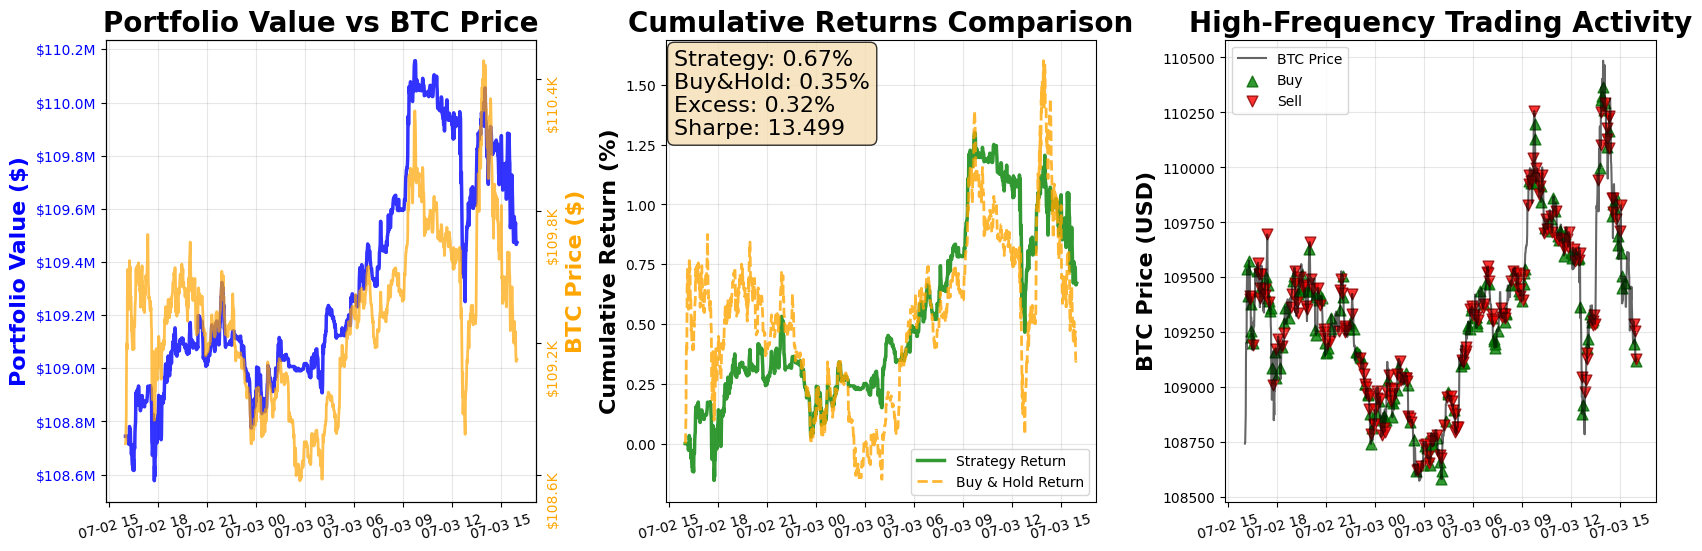

/tmp/ipykernel_174438/2124002802.py:393: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


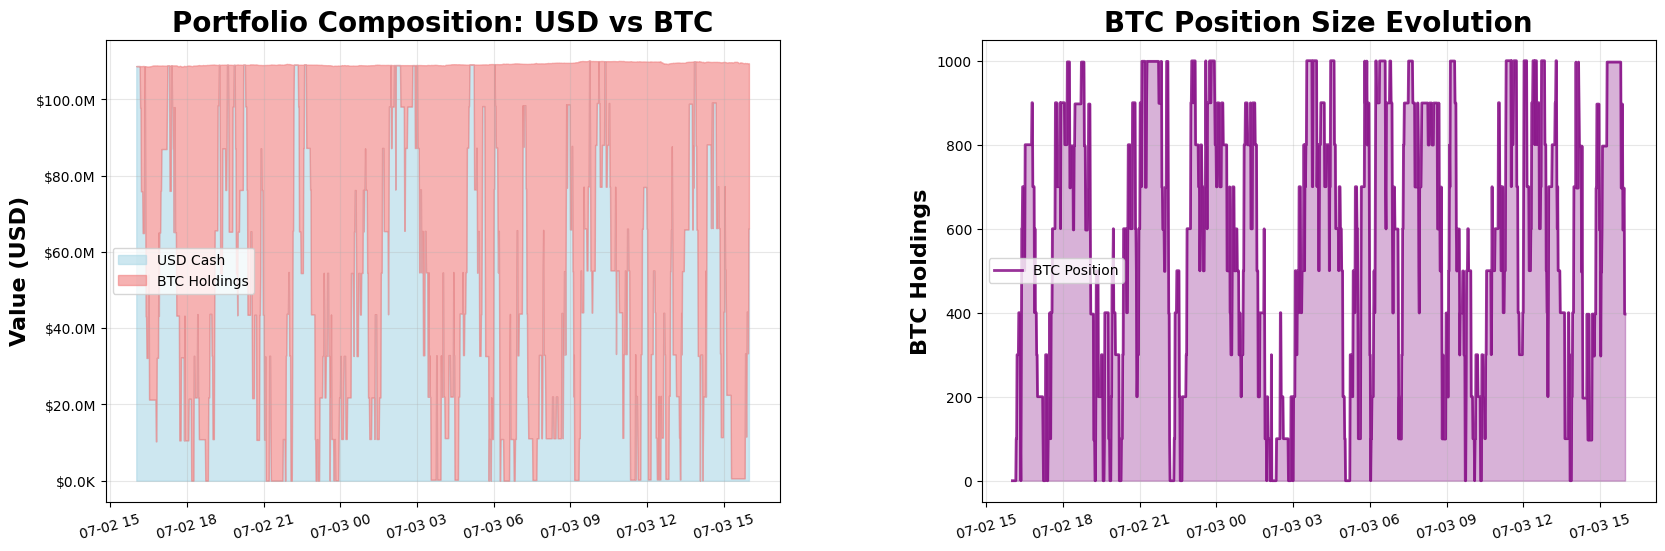

/tmp/ipykernel_174438/2124002802.py:462: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


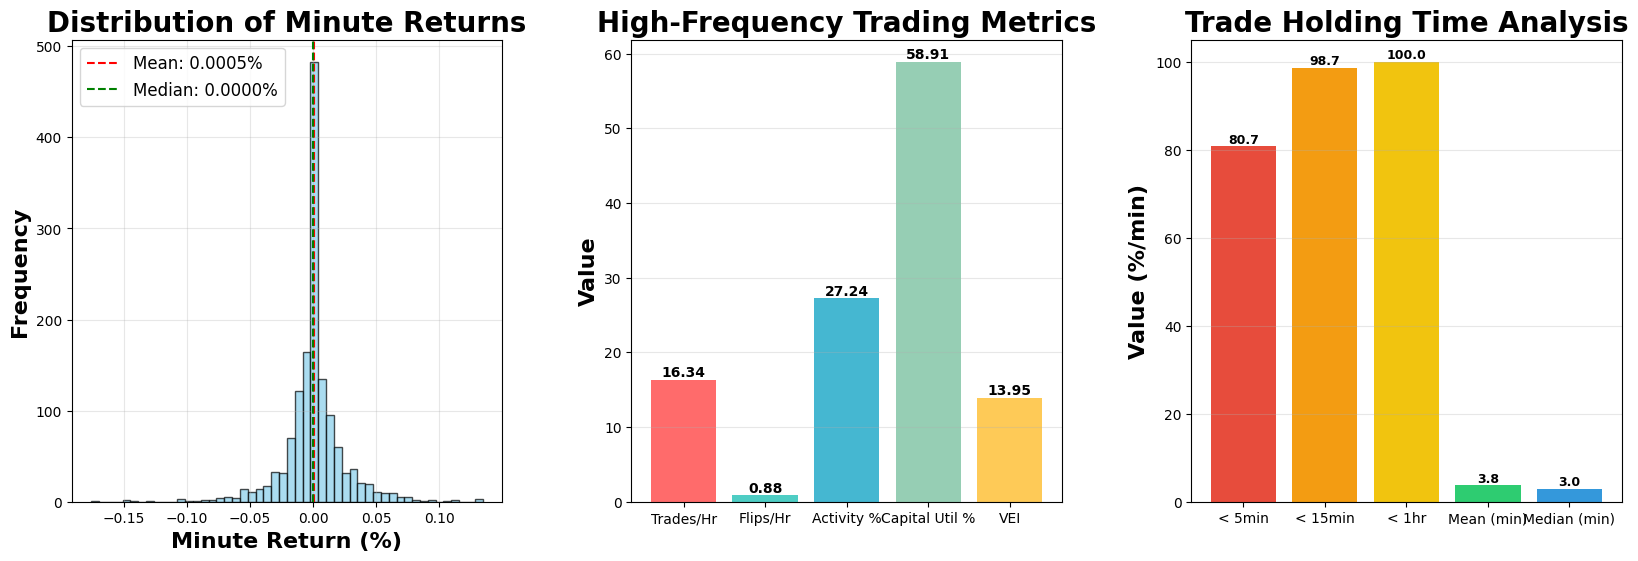


🚀 ENHANCED BITCOIN/CRYPTO HIGH-FREQUENCY TRADING METRICS

📊 BASIC PERFORMANCE METRICS
--------------------------------------------------
Initial Capital (USD)              :            1000
Final Portfolio Value (USD)        :        $109.47M
Total Return (%)                   :           0.67%
Buy & Hold Return (%)              :           0.35%
Excess Return over Buy & Hold (%)  :           0.32%
Annualized Return (%)              :            inf%
Volatility (%)                     :          18.21%
Sharpe Ratio                       :         13.4990
Max Drawdown (%)                   :          -0.82%

⚡ HIGH-FREQUENCY TRADING METRICS
--------------------------------------------------
Microtrade Intensity (trades/hr)   :           16.34
Position Oscillation Rate (flips/hr):            0.88
High-Frequency Activity Rate (%)   :          27.24%
Volatility Exploitation Index      :          1.3954
Average Capital Utilization (%)    :          $58.91
Dollar Turnover Rate (daily)      

In [1297]:
# Step 1: Calculate returns with the accurate function
print("Calculating returns...")
df_results, trade_log, metrics = calculate_returns_minute(df_market_synced, df_operation_synced)

# Step 2: Display basic results
def print_crypto_metrics(metrics):
    print(f"Initial capital: ${metrics['Initial Capital (USD)']:,.2f}")
    print(f"Initial BTC acquired: {metrics['Initial BTC Acquired (BTC)']:.6f} BTC at ${metrics['Final BTC Price (USD)']:,.2f}/BTC")
    print(f"Final portfolio value: ${metrics['Final Portfolio Value (USD)']:,.2f}")
    print(f"Final BTC held: {metrics['Final BTC Held']:.6f} BTC")
    print(f"Final BTC price: ${metrics['Final BTC Price (USD)']:,.2f}\n")
    print(f"Total return: {metrics['Total Return (%)']:.2f}% (${metrics['Total Return (USD)']:,.2f})")
    print(f"Buy & Hold return: {metrics['Buy & Hold Return (%)']:.2f}%")
    print(f"Excess above Buy & Hold: {metrics['Excess Return over Buy & Hold (%)']:.2f}%")
    print(f"BTC price move (%): {metrics['BTC Price Change (%)']:.2f}%")
    print(f"Annualized return: {metrics['Annualized Return (%)']:.2f}%")
    print(f"Annualized volatility: {metrics.get('Volatility (%)', 0):.2f}%")
    print(f"Sharpe ratio: {metrics.get('Sharpe Ratio', 0):.4f}")
    print(f"Max drawdown: {metrics.get('Max Drawdown (%)', 0):.2f}%")
    print(f"Number of executed trades: {metrics['Number of Trades']}")
print("\n=== BASIC PERFORMANCE METRICS ===")
print_crypto_metrics(metrics)

# Step 4: Create the performance visualization
print("\nGenerating performance analysis plots...")
# fig = plot_performance_analysis(df_results, metrics)
fig1, fig2, fig3 = plot_performance_analysis_split(df_results, metrics)

# Step 5: Additional analysis (optional)
print(f"\n=== ADDITIONAL INSIGHTS ===")
print(f"Trading period: {df_results.index[0].strftime('%Y-%m-%d')} to {df_results.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(df_results)}")

if 'Sharpe Ratio' in metrics:
    print(f"Risk-adjusted performance (Sharpe Ratio): {metrics['Sharpe Ratio']:.4f}")
if 'Max Drawdown (%)' in metrics:
    print(f"Maximum drawdown: {metrics['Max Drawdown (%)']:.2f}%")
if 'Volatility (%)' in metrics:
    print(f"Annual volatility: {metrics['Volatility (%)']:.2f}%")

fig1.subplots_adjust(left=0.07, right=0.95, top=0.95, bottom=0.1)
fig1.savefig(f'graphics/FINAI_compare_{ticker}_1.pdf')
fig2.subplots_adjust(left=0.07, right=0.95, top=0.95, bottom=0.1)
fig2.savefig(f'graphics/FINAI_compare_{ticker}_2.pdf')
fig3.subplots_adjust(left=0.07, right=0.95, top=0.95, bottom=0.1)
fig3.savefig(f'graphics/FINAI_compare_{ticker}_3.pdf')

Processing all methods...

Processing SLEIPNIR...
Operation date range: 2025-07-02 16:01:00 to 2025-07-03 16:00:00
Market data entries in date range: 1439
Operation data entries: 1440
After synchronization:
Number of dates: 1439
Date range: 2025-07-02 16:01:00 to 2025-07-03 15:59:00
  Total Return: 0.67%
  Number of Trades: 392
  Final Value: $0.11B
Debug: Checking available methods...
Methods list: ['SLEIPNIR', 'Rule-Based', 'RAG-LLM', 'FinRL']
Available in all_results: ['SLEIPNIR']
Available in all_metrics: ['SLEIPNIR']
Plotting 1 methods: ['SLEIPNIR']


/tmp/ipykernel_174438/2314187807.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_capital = initial_capital * df_combined['close'][0]
/tmp/ipykernel_174438/2124002802.py:825: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


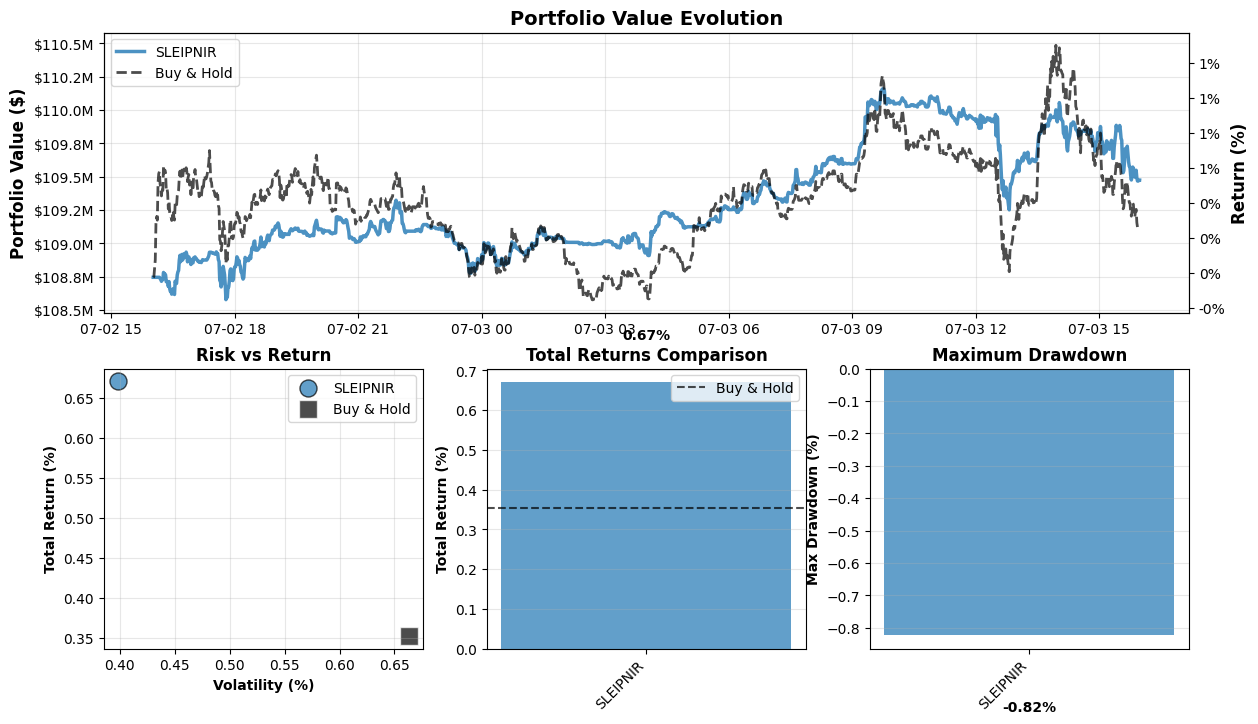

In [1298]:
all_results, all_trade_logs, all_metrics = calculate_returns_for_all_methods(df_market, df_operations, methods)

# Debug: Check what methods we actually have
print("Debug: Checking available methods...")
print("Methods list:", methods)
print("Available in all_results:", list(all_results.keys()) if 'all_results' in globals() else "all_results not defined")
print("Available in all_metrics:", list(all_metrics.keys()) if 'all_metrics' in globals() else "all_metrics not defined")

# # Create the comparison plot with error handling
# try:
#     fig_comparison = plot_methods_comparison(all_results, all_metrics, methods)
#     if fig_comparison is None:
#         print("Failed to create comparison plot - no valid methods found")
#     fig_comparison.savefig(f'graphics/FINAI_compare_{ticker}.pdf')
# except Exception as e:
#     print(f"Error creating comparison plot: {e}")
#     print("Let's debug the data structure...")
    
#     # Debug information
#     if 'all_results' in globals():
#         print(f"all_results keys: {list(all_results.keys())}")
#         for key in all_results.keys():
#             print(f"  {key}: {type(all_results[key])}, shape: {all_results[key].shape if hasattr(all_results[key], 'shape') else 'no shape'}")
    
#     if 'all_metrics' in globals():
#         print(f"all_metrics keys: {list(all_metrics.keys())}")
#         for key in all_metrics.keys():
#             print(f"  {key}: {type(all_metrics[key])}")

fig_comparison = plot_methods_comparison(all_results, all_metrics, methods)
if fig_comparison is None:
    print("Failed to create comparison plot - no valid methods found")
fig_comparison.subplots_adjust(left=0.07, right=0.95, top=0.95, bottom=0.1)
# fig_comparison.savefig(f'graphics/FINAI_compare_{ticker}.pdf')
# fig_comparison.savefig(f'graphics/FINAI_compare_{ticker}.svg')
            